# Dataset exploration

### imports and loading datasets

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis


In [150]:
df = pd.read_csv('dataset.csv')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female


### Finding  the missing  values

In [151]:
df.isnull().sum()

species               0
island                0
bill_length_mm        7
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  16
dtype: int64

### Examining the datatypes in columns

In [152]:
df.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

In [153]:
species, island = df['species'].unique(), df['island'].unique()

In [154]:
columns = df.columns
columns

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

In [155]:
numerical_column = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm', 'body_mass_g']

## Filling the missing values 

### Numerical Datatypes will be imputed based on the mean of the given species, island pair for the given attribute
> Assuming the fact that each spieces in a same island will have different characteristics 

The `ValueDictionary` will contain pair wise mean of each column
for eg. `ValueDictionary[Adelie-Torgersen] = {'bill_length_mm': p, 'bill_depth_mm': q, 'flipper_length_mm': s, 'body_mass_g': t }`

In [156]:
ValueDictionary = {}
for sp in species:
    for isl in island:
        subset = df[(df['species'] == sp) & (df['island'] == isl)]
        ValueDictionary[f'{sp}-{isl}'] ={}
        for ncol in numerical_column:
            val = subset[ncol].mean(skipna=True)
            ValueDictionary[f'{sp}-{isl}'][ncol] = val

In [157]:
ValueDictionary

{'Adelie-Torgersen': {'bill_length_mm': 38.950980392156865,
  'bill_depth_mm': 18.429411764705883,
  'flipper_length_mm': 191.19607843137254,
  'body_mass_g': 3919.1176470588234},
 'Adelie-Biscoe': {'bill_length_mm': 38.975,
  'bill_depth_mm': 18.37045454545455,
  'flipper_length_mm': 188.79545454545453,
  'body_mass_g': 3709.659090909091},
 'Adelie-Dream': {'bill_length_mm': 38.501785714285695,
  'bill_depth_mm': 18.251785714285717,
  'flipper_length_mm': 189.73214285714286,
  'body_mass_g': 3688.3928571428573},
 'Gentoo-Torgersen': {'bill_length_mm': nan,
  'bill_depth_mm': nan,
  'flipper_length_mm': nan,
  'body_mass_g': nan},
 'Gentoo-Biscoe': {'bill_length_mm': 47.51596638655461,
  'bill_depth_mm': 14.982113821138206,
  'flipper_length_mm': 217.1869918699187,
  'body_mass_g': 5133.739837398374},
 'Gentoo-Dream': {'bill_length_mm': nan,
  'bill_depth_mm': nan,
  'flipper_length_mm': nan,
  'body_mass_g': nan},
 'Chinstrap-Torgersen': {'bill_length_mm': nan,
  'bill_depth_mm': nan,

In [158]:
for sp in species:
    for isl in island:        
        for ncol in numerical_column:
            mask = (df['species'] == sp) & (df['island'] == isl) & df[ncol].isna()
            df.loc[mask, ncol] =  ValueDictionary[f'{sp}-{isl}'][ncol]

In [159]:
df.isnull().sum()

species               0
island                0
bill_length_mm        0
bill_depth_mm         0
flipper_length_mm     0
body_mass_g           0
sex                  16
dtype: int64

In [160]:
if 'species-Adelie' not in df.columns:
    for sp in ['Adelie', 'Gentoo']:
        df[f'species-{sp}'] = (df['species'] == sp).astype(int)

    for isl in ['Torgersen', 'Biscoe']:
        df[f'island-{isl}'] = (df['island'] == isl).astype(int)


In [161]:
df.sex.unique()

array(['male', 'female', nan, 'unknown'], dtype=object)

> We will impute the value of `nan` and `unKnown` using the rest to fit a random forest estimator and 

In [162]:
df['sex'] = df['sex'].map({'male': 1, 'female': 0, 'UnKnown': np.nan})

In [163]:
df_old = df.copy()

In [164]:
df.drop(axis = 1,columns=['species','island'], inplace=True)

In [165]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import numpy as np

def rf_imputer(X, y):
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X[y.notnull()], y[y.notnull()])
    return rf.predict(X[y.isnull()])

other_columns = [col for col in df.columns if col != 'sex']

simple_imputer = SimpleImputer(strategy='most_frequent')
df[other_columns] = simple_imputer.fit_transform(df[other_columns])

mask = df['sex'].isnull()
df.loc[mask, 'sex'] = rf_imputer(df[other_columns], df['sex'])

In [166]:
df.isnull().sum()

bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
species-Adelie       0
species-Gentoo       0
island-Torgersen     0
island-Biscoe        0
dtype: int64

> So we have imputed all the missing values

In [167]:
df[20:30]

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,species-Adelie,species-Gentoo,island-Torgersen,island-Biscoe
20,37.8,18.3,174.0,3400.0,0.0,1.0,0.0,0.0,1.0
21,37.7,18.7,180.0,3600.0,1.0,1.0,0.0,0.0,1.0
22,35.9,19.2,189.0,3800.0,0.0,1.0,0.0,0.0,1.0
23,38.2,18.1,185.0,3950.0,1.0,1.0,0.0,0.0,1.0
24,38.8,17.2,180.0,3800.0,1.0,1.0,0.0,0.0,1.0
25,35.3,18.9,187.0,3800.0,0.0,1.0,0.0,0.0,1.0
26,40.6,18.6,183.0,3550.0,1.0,1.0,0.0,0.0,1.0
27,40.5,17.9,187.0,3200.0,0.0,1.0,0.0,0.0,1.0
28,37.9,18.6,172.0,3150.0,0.0,1.0,0.0,0.0,1.0
29,40.5,18.9,180.0,3950.0,1.0,1.0,0.0,0.0,1.0


### Question: 2
* What is the average body_mass_g for Gentoo penguins?

In [168]:
avg_body_mass_g_gentoo = df[df['species-Gentoo'] == 1]['body_mass_g'].mean()
print(f'The average body_mass_g for Gentoo penguins is {avg_body_mass_g_gentoo:.2f}')

The average body_mass_g for Gentoo penguins is 5133.74


### Question: 3 & 4
* Analyze the skewness and kurtosis of each feature for different species
* Identify which features in the dataset have outliers. Provide the method used to detect them and visualize the outliers.
> Step to find outlier (using interquartile range)
> * Sort the data in ascending order
> * find median (Q2)
> * Divide the dataset in 2 parts, before median and after median
> * find median of first part (Q1)
> * find median of second part (Q3) and computer Interquratile range(IQR) = Q3 - Q1 
> * The point is outlier if and only if `Q1 - 1.5IQR > x or x > Q3 + 1.5IQR`

**NOTE** I am finding for each species separately

In [169]:
import numpy as np

def find_outlier_indexes(data):
    data_array = np.array(data)
    # calculate Q1 and Q2
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    # Define IQR
    IQR = Q3 - Q1
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Find outlier indexes
    outlier_indexes = [(index, value) for index, value in enumerate(data) if value < lower_bound or value > upper_bound]
    return outlier_indexes




Species: Adelie
Bill Length Skewness: 0.15939821071236976
Bill Length Kurtosis: -0.17330899351699802
Bill Depth Skewness: 0.31772121915603857
Bill Depth Kurtosis: -0.0793389630348651

Species: Gentoo
Bill Length Skewness: 0.6899708614688632
Bill Length Kurtosis: 1.4074174886702489
Bill Depth Skewness: 0.321562291630284
Bill Depth Kurtosis: -0.5889488703478802

Species: Chinstrap
Bill Length Skewness: -0.11867337676567673
Bill Length Kurtosis: 0.005082702932146965
Bill Depth Skewness: 0.0067259608078862046
Bill Depth Kurtosis: -0.898739653084359


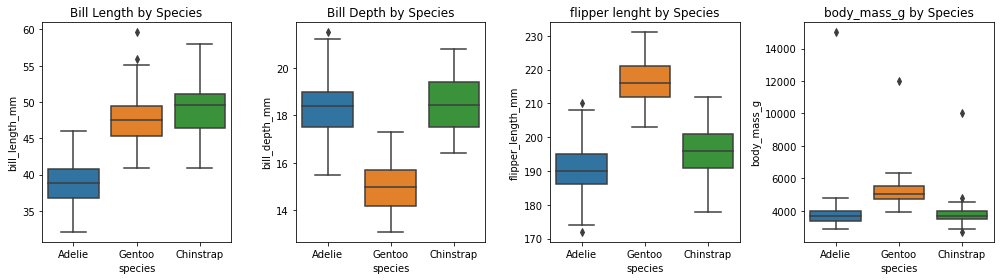

In [170]:
for sp in species:
    species_data = df_old[df_old['species'] == sp]
    print(f"\nSpecies: {sp}")
    print(f"Bill Length Skewness: {skew(species_data['bill_length_mm'])}")
    print(f"Bill Length Kurtosis: {kurtosis(species_data['bill_length_mm'])}")
    print(f"Bill Depth Skewness: {skew(species_data['bill_depth_mm'])}")
    print(f"Bill Depth Kurtosis: {kurtosis(species_data['bill_depth_mm'])}")


fig, axes = plt.subplots(1, 4, figsize=(14, 4))

sns.boxplot(x='species', y='bill_length_mm', data=df_old, ax=axes[0])
axes[0].set_title('Bill Length by Species')

sns.boxplot(x='species', y='bill_depth_mm', data=df_old, ax=axes[1])
axes[1].set_title('Bill Depth by Species')

sns.boxplot(x='species', y='flipper_length_mm', data=df_old, ax=axes[2])
axes[2].set_title('flipper lenght by Species')


sns.boxplot(x='species', y='body_mass_g', data=df_old, ax=axes[3])
axes[3].set_title('body_mass_g by Species')


plt.tight_layout()
plt.show()


### Overall Interpretation: 

####  Adelie penguins' distributions for beak length and depth are almost symmetrical, and their much flatter tails suggest fewer outliers.

####  In comparison to other species, gentoo penguins have a considerable right skew in bill length and a peaked distribution with heavier tails, indicating a greater range of extreme values.

####  The distributions of bill length and depth in chinstrap penguins are almost symmetrical, while the distribution of bill depth is noticeably flat, indicating fewer extreme values.


### Discussion about outliers

* In the above discussed graph points represented in **`diamond`** shape are the outliers. We can use the custom function  **`find_outlier_indexes`** mentioned above to find outliers.

In [172]:
for col in numerical_column:
    vals = list(df[col])
    if len(find_outlier_indexes(vals)):
        print(f"{col} has outliers")

body_mass_g has outliers


### Question: 5 Does this dataset contribute to the curse of dimensionality? If yes perform PCA

#### Curse of Dimensionality
* Correlation matrix can be used to determine whether the feature is highly dependent to find multi colinearity


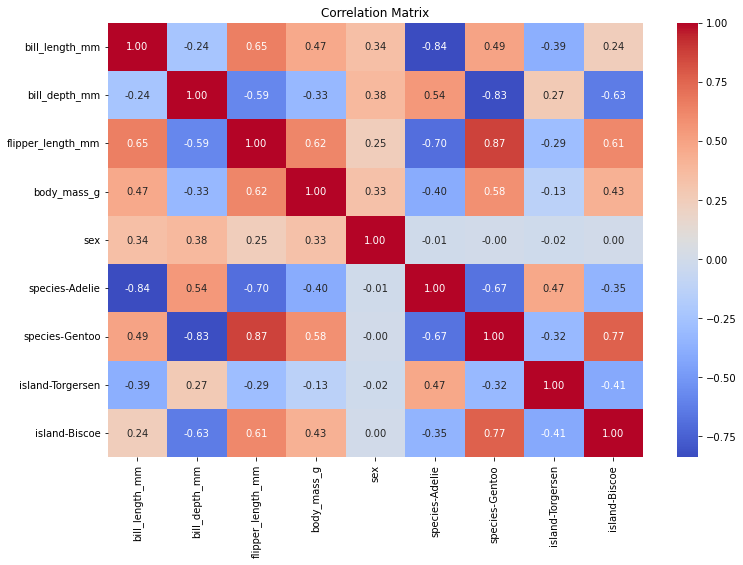

In [134]:
df = df.astype(float)

corr_matrix = df.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

##### As we can see the features highly correlated, we can use PCA to reduce the dimension

#### PCA dimesionality reduction

In [141]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

pca.fit(scaled_data)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()


n_components = sum(cumulative_variance < 0.95) + 1  
print(f"Number of components to retain for 95% variance: {n_components}")

pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(scaled_data)

Number of components to retain for 95% variance: 6


In [142]:
print(f"Number of feature reduced {df.shape[1] - 6}")

Number of feature reduced 3


In [145]:
reduced_data_df = pd.DataFrame(reduced_data)

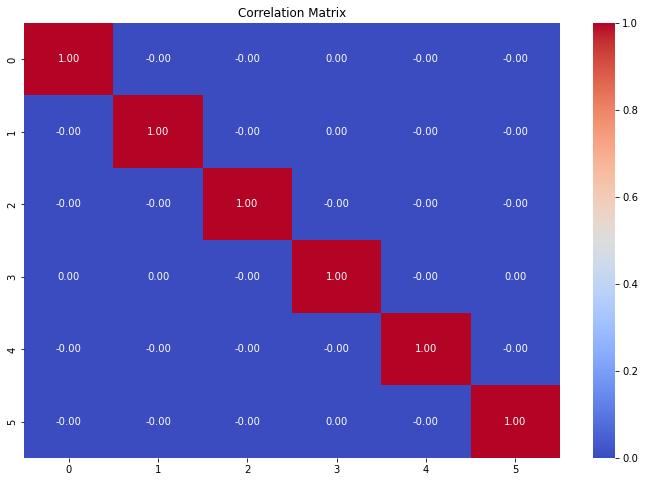

In [146]:
corr_matrix = reduced_data_df.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Question:6 Use bill_length_mm vs bill_depth_mm and plot 7 different graphs to visualize them.

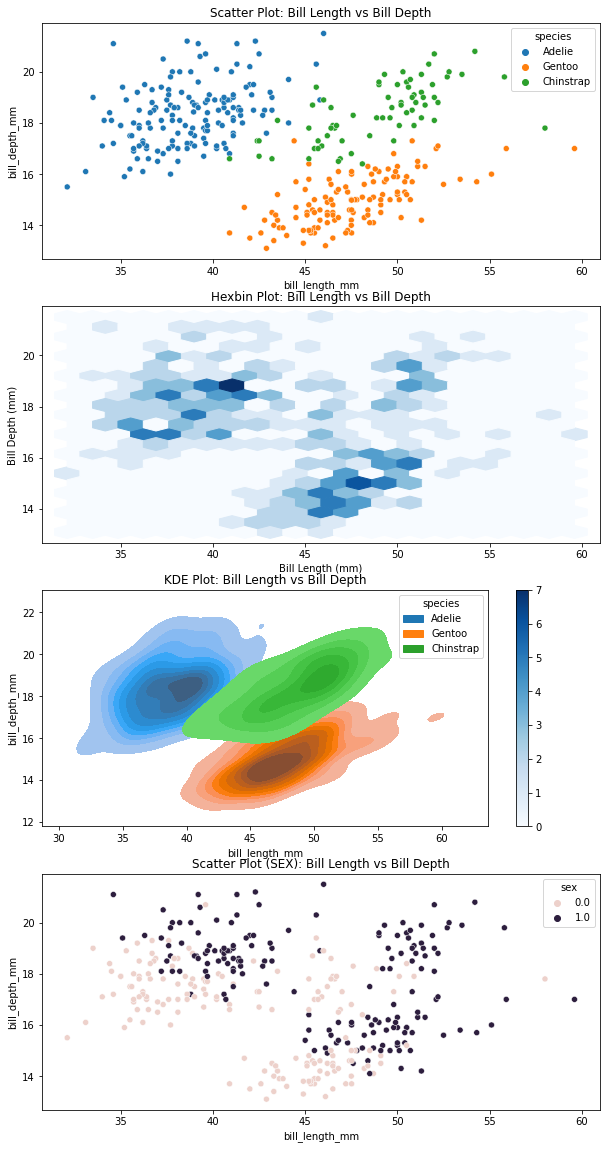

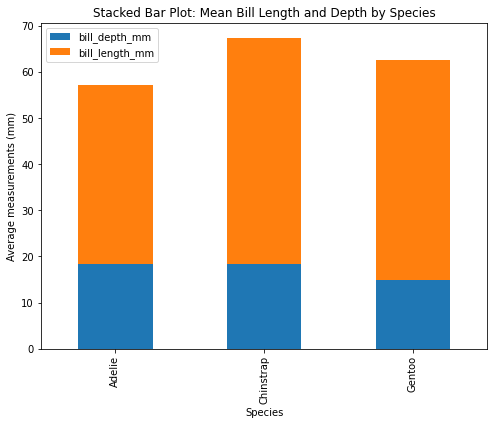

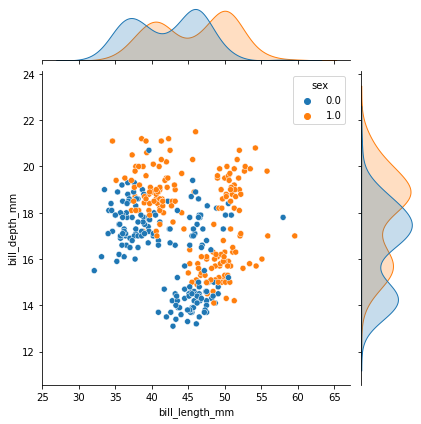

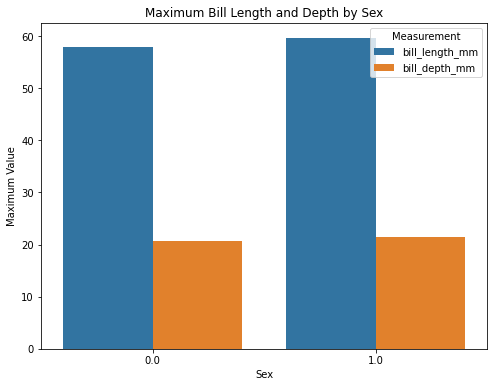

In [120]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
axes = axes.flatten()

# 1. Scatter Plot
sns.scatterplot(x='bill_length_mm', y='bill_depth_mm', hue='species', data=df_old, ax=axes[0])
axes[0].set_title('Scatter Plot: Bill Length vs Bill Depth')



# 2. Hexbin Plot 
hb = axes[1].hexbin(df_old['bill_length_mm'], df_old['bill_depth_mm'], gridsize=20, cmap='Blues')
axes[1].set_title('Hexbin Plot: Bill Length vs Bill Depth')
axes[1].set_xlabel('Bill Length (mm)')
axes[1].set_ylabel('Bill Depth (mm)')
cb = fig.colorbar(hb, ax=axes[2], orientation='vertical')

# 3. KDE Plot
sns.kdeplot(x='bill_length_mm', y='bill_depth_mm', hue='species', data=df_old, ax=axes[2], fill=True)
axes[2].set_title('KDE Plot: Bill Length vs Bill Depth')


# 4. scatter plot w/ sex

sns.scatterplot(x='bill_length_mm', y='bill_depth_mm', hue='sex', data=df_old, ax=axes[3])
axes[3].set_title('Scatter Plot (SEX): Bill Length vs Bill Depth')





# 5. Bar plot on mean values by species
df_pivot = df_old.pivot_table(index='species', values=['bill_length_mm', 'bill_depth_mm'], aggfunc=np.mean)
df_pivot.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Stacked Bar Plot: Mean Bill Length and Depth by Species')
plt.ylabel('Average measurements (mm)')
plt.xlabel('Species')

# 6. Joint plot bill lenght and depth against sex

sns.jointplot(data=df, x='bill_length_mm', y='bill_depth_mm', hue='sex', kind='scatter')
plt.show()


# 7. Maximum value bill lenght and depth against sex
max_values = df.groupby('sex')[['bill_length_mm', 'bill_depth_mm']].max().reset_index()
max_values_melted = max_values.melt(id_vars='sex', var_name='Measurement', value_name='Maximum Value')
plt.figure(figsize=(8, 6))
sns.barplot(data=max_values_melted, x='sex', y='Maximum Value', hue='Measurement')
plt.title('Maximum Bill Length and Depth by Sex')
plt.xlabel('Sex')
plt.ylabel('Maximum Value');

### Question:7 Find the maximum flipper_length_mm for each combination of species and island. Which species has the longest flippers on each island? 

In [126]:
for isl in island:
    maximum_island = 0
    sps = []
    for sp in species:
        vals = df_old[(df_old['species'] == sp) & (df_old['island'] == isl)]['flipper_length_mm']
        if len(vals):
            highest_val = max(vals)
            print(f"Maximum Value of species {sp} in island {isl} is: {highest_val}")
            if maximum_island == highest_val:
                sps.append(sp)
                maximum_island = highest_val
                    
            elif maximum_island < highest_val:
                sps = []
                sps.append(sp)
                maximum_island = highest_val
            print(f"Maximum flipper value for {sp} in {isl} is {highest_val}")   
        else:
            print(f'Species {sp} does not leave in {isl} ')    
    
    print('Species with longest flippers is/are', end = " ")
    for sp in sps:
        print(f'{sp}', end = ' ')
    print()    

Maximum Value of species Adelie in island Torgersen is: 210.0
Maximum flipper value for Adelie in Torgersen is 210.0
Species Gentoo does not leave in Torgersen 
Species Chinstrap does not leave in Torgersen 
Species with longest flippers is/are Adelie 
Maximum Value of species Adelie in island Biscoe is: 203.0
Maximum flipper value for Adelie in Biscoe is 203.0
Maximum Value of species Gentoo in island Biscoe is: 231.0
Maximum flipper value for Gentoo in Biscoe is 231.0
Species Chinstrap does not leave in Biscoe 
Species with longest flippers is/are Gentoo 
Maximum Value of species Adelie in island Dream is: 208.0
Maximum flipper value for Adelie in Dream is 208.0
Species Gentoo does not leave in Dream 
Maximum Value of species Chinstrap in island Dream is: 212.0
Maximum flipper value for Chinstrap in Dream is 212.0
Species with longest flippers is/are Chinstrap 


### Question: 8 Perform z-score normalization on this dataset

In [147]:
scaler = StandardScaler()

normalized_data = scaler.fit_transform(df)

df_normalized = pd.DataFrame(normalized_data, columns=df.columns, index=df.index)

In [148]:
df_normalized.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,species-Adelie,species-Gentoo,island-Torgersen,island-Biscoe
0,-0.887017,0.787186,-1.420072,-0.471054,1.0,1.123903,-0.750757,2.36968,-0.977008
1,-0.813558,0.127570,-1.063883,-0.426230,-1.0,1.123903,-0.750757,2.36968,-0.977008
2,-0.666638,0.432008,-0.422743,-0.919297,-1.0,1.123903,-0.750757,2.36968,-0.977008
3,-0.914385,0.649891,-0.693726,-0.319442,1.0,1.123903,-0.750757,2.36968,-0.977008
4,-1.327775,1.091625,-0.565219,-0.740000,-1.0,1.123903,-0.750757,2.36968,-0.977008
